#  Synthetic calibration

In this module we employ our neural network in synthetic calibration.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import QuantLib as ql
import time
import pickle

import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from IPython import display
from sklearn.metrics import r2_score

import HestonUtils
from HestonNN import Net

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [15, 10]

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU


Loss functions that we want to minimize the 5 Heston parameters over:

In [2]:
def nn_loss(x, observed_params, y_trues, net):
    n = len(y_trues)
    xs = np.array(list(x)*n).reshape(-1,5)
    nn_params = np.hstack((observed_params[:,:2], xs, observed_params[:,2:]))
    moneyness = nn_params[:,0]
    nn_params = torch.Tensor(nn_params).float().to(device)
    with torch.no_grad():
        y_preds = net(nn_params).to('cpu').detach().numpy().flatten()
    return np.mean((1/moneyness)**2*np.square(y_preds - y_trues))

def ql_loss(x, observed_params, y_trues):
    n = len(y_trues)
    xs = np.array(list(x)*n).reshape(-1,5)
    nn_params = np.hstack((observed_params[:,:2], xs, observed_params[:,2:]))
    moneyness = nn_params[:,0]
    ql_params = HestonUtils.convertNNtoQLparams(nn_params)
    y_preds = np.array([HestonUtils.QuantlibHestonPrice(*ql_params[i]) for i in range(n)])
    return np.mean((1/moneyness)**2*np.square(y_trues - y_preds))

Functions used to calibrate the 5 Heston parameters:

In [7]:
def nn_calibration(net, observed_params, observed_price, bounds):
    res = differential_evolution(nn_loss, bounds=bounds, args=(observed_params, observed_price, net), 
                                 popsize=10, constraints=HestonUtils.feller_con, polish=False)
    return res

def ql_calibration(observed_params, observed_price, bounds):
    res = differential_evolution(ql_loss, bounds=bounds, args=(observed_params, observed_price), 
                                 popsize=10, constraints=HestonUtils.feller_con, polish=False, maxiter=100)
    return res

Load neural networks:

In [6]:
narrow_net = torch.load('models/run_133')
wide_net = torch.load('models/run_134')

## Comparing neural network calibration and traditional calibration

We first compare the neural network calibration with the traditional calibration.

In [5]:
def calibrationComparison(net=None, data_type='NARROW', N=100, M=30, seed=0):
    np.random.seed(seed)
    
    if data_type == 'NARROW':
        bounds = ((0,0.5), (0,3), (0,0.5), (0,1), (-0.9,0))
    else:
        bounds = ((0,1), (0,10), (0,1), (0,2), (-1,0))
    bounds = np.array(bounds)
    
    x_stars = np.zeros((N,5))
    x_cals_nn = np.zeros((N,5))
    fevs_nn = []
    funs_nn = [] 
    times_nn = []
    
    x_cals_ql = np.zeros((N,5))
    fevs_ql = []
    funs_ql = []
    times_ql = []
    for i in range(N):
        x_star = np.random.uniform(bounds[:,0], bounds[:,1])
        while 2*x_star[1]*x_star[2] <= x_star[3]**2:
            x_star = np.random.uniform(bounds[:,0], bounds[:,1])
        x_stars[i] = x_star
        Ss = np.random.uniform(low=0.5,high=1.5,size=M)
        Ks = np.array([1.]*M)
        moneyness = Ss / Ks
        current_dates = np.array([ql.Date(1,1,2019)]*M)
        Ts = np.random.randint(low=1,high=365*2+1,size=M)
        maturity_dates = current_dates + Ts
        Ts = Ts / 365
        rs = np.array([0.0]*M) + np.random.uniform(low=0,high=0.05)
        qs = np.array([0.0]*M) + np.random.uniform(low=0,high=0.05)
        
        observed_params = np.array([moneyness, Ts, rs, qs]).T
        
        y_trues = np.array([HestonUtils.QuantlibHestonPrice(Ss[i], Ks[i], current_dates[i], maturity_dates[i],
                                                            *x_star, rs[i], qs[i]) for i in range(M)])
        
        time_start = time.time()
        x_cal_nn = nn_calibration(net, observed_params, y_trues, bounds)
        times_nn.append(time.time()-time_start)
        
        time_start = time.time()
        x_cal_ql = ql_calibration(observed_params, y_trues, bounds)
        times_ql.append(time.time()-time_start)
        
        x_cals_nn[i] = x_cal_nn.x
        fevs_nn.append(x_cal_nn.nfev)
        funs_nn.append(x_cal_nn.fun)
        
        x_cals_ql[i] = x_cal_ql.x
        fevs_ql.append(x_cal_ql.nfev)
        funs_ql.append(x_cal_ql.fun)
    fevs_nn = np.array(fevs_nn).reshape(-1,1)
    funs_nn = np.array(funs_nn).reshape(-1,1)
    times_nn = np.array(times_nn).reshape(-1,1)
    fevs_ql = np.array(fevs_ql).reshape(-1,1)
    funs_ql = np.array(funs_ql).reshape(-1,1)
    times_ql = np.array(times_ql).reshape(-1,1)
    return x_stars, np.hstack((x_cals_nn, funs_nn, fevs_nn, times_nn)), np.hstack((x_cals_ql, funs_ql, fevs_ql, times_ql))

As an example, we compare the calibration using $\mathcal{NN}_{narrow}$ against traditional calibration (here we use some previously stored data via the `pickle` package).

In [7]:
# narrow = calibrationComparison(net=narrow_net, data_type='NARROW', N=200, M=30)

In [3]:
narrow_comp = pickle.load(open('results/calibration/narrow_comp.p', 'rb'))
wide_comp = pickle.load(open('results/calibration/wide_comp.p', 'rb'))

In [8]:
narrow_actual = narrow_comp[0]
narrow_nn = narrow_comp[1]
narrow_ql = narrow_comp[2]
print('MSEs')
print(np.mean(np.square(narrow_nn[:,:5]-narrow_actual),axis=0))
print(np.mean(np.square(narrow_ql[:,:5]-narrow_actual),axis=0))
print('MAEs')
print(np.mean(np.abs(narrow_nn[:,:5]-narrow_actual),axis=0))
print(np.mean(np.abs(narrow_ql[:,:5]-narrow_actual),axis=0))

# funcs
print('function values')
print(np.mean(narrow_nn[:,5]))
print(np.mean(narrow_ql[:,5]))

# computations
print('avg number of function evaluations')
print(np.mean(narrow_nn[:,6]))
print(np.mean(narrow_ql[:,6]))

# time
print('avg calibration time')
print(np.mean(narrow_nn[:,7]))
print(np.mean(narrow_ql[:,7]))

MSEs
[2.05453313e-07 2.43654397e-03 4.18589205e-06 1.58228773e-03
 1.96500128e-02]
[5.73012553e-08 1.13513393e-03 5.97966449e-05 8.69742270e-05
 8.82361619e-03]
MAEs
[0.00025982 0.01936723 0.00076915 0.01284924 0.04580554]
[6.09523871e-05 5.87745755e-03 7.92069006e-04 3.34947572e-03
 2.41613921e-02]
function values
1.2234765133736898e-09
7.253100007891368e-11
avg number of function evaluations
5761.455
4868.1
avg calibration time
5.446858032941818
166.58061676740647


## Performance of neural network in calibration

Here we investigate further into the performance of neural networks in calibration.

In [9]:
def calibrationAnalysis(net=None, data_type='NARROW', N=100, M=30, seed=0):
    np.random.seed(seed)
    
    if data_type == 'NARROW':
        bounds = ((0,0.5), (0,3), (0,0.5), (0,1), (-0.9,0))
    else:
        bounds = ((0,1), (0,10), (0,1), (0,2), (-1,0))
    bounds = np.array(bounds)
    
    x_stars = np.zeros((N,5))
    x_cals_nn = np.zeros((N,5))
    funs_nn = [] 
    times_nn = []
    for i in range(N):
        x_star = np.random.uniform(bounds[:,0], bounds[:,1])
        while 2*x_star[1]*x_star[2] <= x_star[3]**2:
            x_star = np.random.uniform(bounds[:,0], bounds[:,1])
        x_stars[i] = x_star
        Ss = np.random.uniform(low=0.5,high=1.5,size=M)
        Ks = np.array([1.]*M)
        moneyness = Ss / Ks
        current_dates = np.array([ql.Date(1,1,2019)]*M)
        Ts = np.random.randint(low=1,high=365*2+1,size=M)
        maturity_dates = current_dates + Ts
        Ts = Ts / 365
        rs = np.array([0.0]*M) + np.random.uniform(low=0,high=0.05)
        qs = np.array([0.0]*M) + np.random.uniform(low=0,high=0.05)
        
        observed_params = np.array([moneyness, Ts, rs, qs]).T
        
        y_trues = np.array([HestonUtils.QuantlibHestonPrice(Ss[i], Ks[i], current_dates[i], maturity_dates[i],
                                                            *x_star, rs[i], qs[i]) for i in range(M)])
        
        time_start = time.time()
        x_cal_nn = nn_calibration(net, observed_params, y_trues, bounds)
        times_nn.append(time.time()-time_start)
        
        x_cals_nn[i] = x_cal_nn.x
        funs_nn.append(x_cal_nn.fun)
    funs_nn = np.array(funs_nn).reshape(-1,1)
    times_nn = np.array(times_nn).reshape(-1,1)
    return x_stars, np.hstack((x_cals_nn, funs_nn, times_nn))


### $\mathcal{NN}_{narrow}$ on narrow dataset

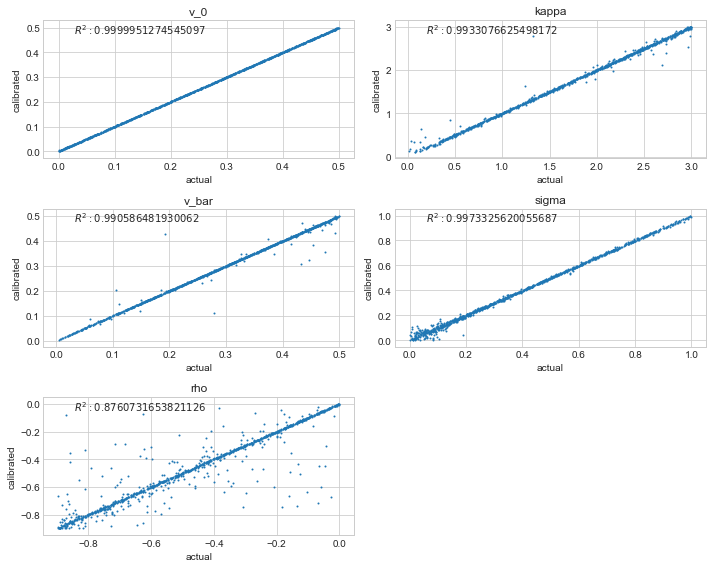

In [10]:
narrow_actual = np.load('results/calibration/narrow0.npy')
narrow_nn = np.load('results/calibration/narrow1.npy')

names = ['v_0', 'kappa', 'v_bar', 'sigma', 'rho']
plt.rcParams['figure.figsize'] = [10, 8]
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(narrow_actual[:,i], narrow_nn[:,i],s=1)
    plt.title(names[i])
    plt.text(plt.xlim()[0]+0.1*(plt.xlim()[1]-plt.xlim()[0]),plt.ylim()[1]-0.1*(plt.ylim()[1]-plt.ylim()[0]), f'$R^2: {r2_score(narrow_actual[:,i], narrow_nn[:,i])}$')
    plt.xlabel('actual')
    plt.ylabel('calibrated')
plt.tight_layout()
plt.show()

### $\mathcal{NN}_{wide}$ on wide dataset

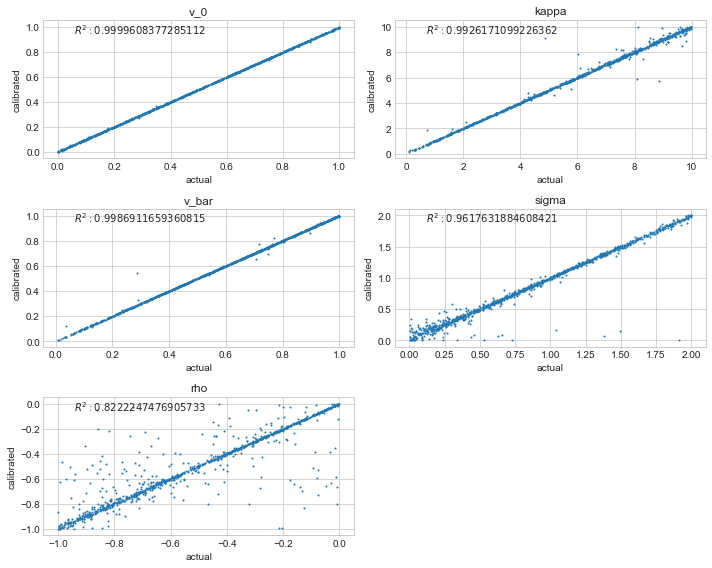

In [11]:
wide_actual = np.load('results/calibration/wide0.npy')
wide_nn = np.load('results/calibration/wide1.npy')

names = ['v_0', 'kappa', 'v_bar', 'sigma', 'rho']
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(wide_actual[:,i], wide_nn[:,i],s=1)
    plt.text(plt.xlim()[0]+0.1*(plt.xlim()[1]-plt.xlim()[0]),plt.ylim()[1]-0.1*(plt.ylim()[1]-plt.ylim()[0]), f'$R^2: {r2_score(wide_actual[:,i], wide_nn[:,i])}$')
    plt.title(names[i])
    plt.xlabel('actual')
    plt.ylabel('calibrated')
plt.tight_layout()
plt.show()

### $\mathcal{NN}_{narrow}$ on wide dataset

0.0011426390606310895
[0.20251968 4.11286712 0.14837072 0.67774241 0.27637213]
4.567125883817673
42


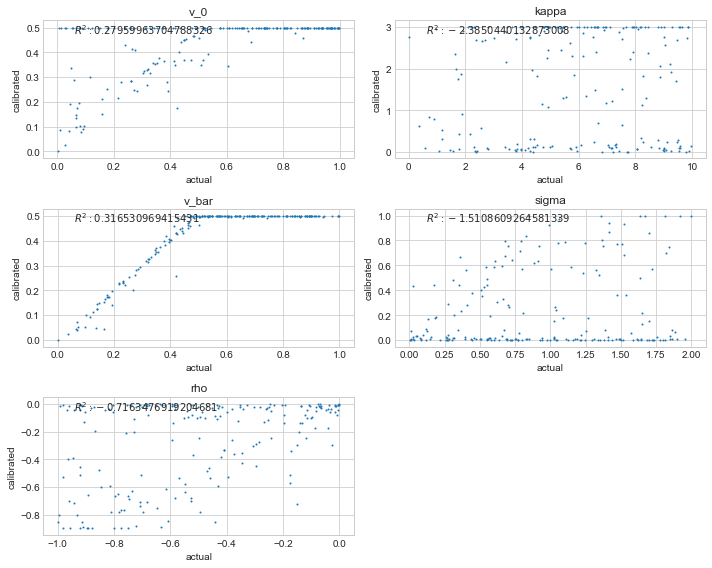

In [15]:
narrow_cross_true = np.load('results/calibration/narrow_cross0.npy')
narrow_cross_cal  = np.load('results/calibration/narrow_cross1.npy')

narrow_MAE = np.mean(np.abs(narrow_cross_cal[:,:5]-narrow_cross_true), axis=0)
narrow_funs = np.mean(narrow_cross_cal[:,5])
narrow_times = np.mean(narrow_cross_cal[:,6])
print(narrow_funs)
print(narrow_MAE)
print(narrow_times)

print(sum(np.array(narrow_cross_cal[:,5]) < 1e-8))

names = ['v_0', 'kappa', 'v_bar', 'sigma', 'rho']
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(narrow_cross_true[:200,i], narrow_cross_cal[:200,i],s=1)
    plt.text(plt.xlim()[0]+0.1*(plt.xlim()[1]-plt.xlim()[0]),plt.ylim()[1]-0.1*(plt.ylim()[1]-plt.ylim()[0]), f'$R^2: {r2_score(narrow_cross_true[:,i], narrow_cross_cal[:,i])}$')
    plt.title(names[i])
    plt.xlabel('actual')
    plt.ylabel('calibrated')
plt.tight_layout()
plt.show()

### $\mathcal{NN}_{wide}$ on narrow dataset

4.161381198015288e-09
[0.00044589 0.03971819 0.00307833 0.01681718 0.0565263 ]
10.40630541729927


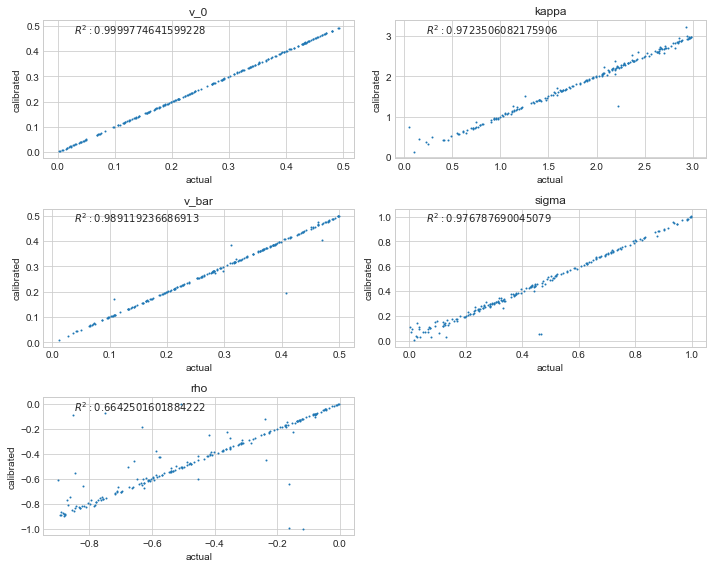

In [17]:
wide_cross_true = np.load('results/calibration/wide_cross0.npy')
wide_cross_cal  = np.load('results/calibration/wide_cross1.npy')

wide_MAE = np.mean(np.abs(wide_cross_cal[:,:5]-wide_cross_true), axis=0)
wide_funs = np.mean(wide_cross_cal[:,5])
wide_times = np.mean(wide_cross_cal[:,6])
print(wide_funs)
print(wide_MAE)
print(wide_times)

names = ['v_0', 'kappa', 'v_bar', 'sigma', 'rho']
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(wide_cross_true[:200,i], wide_cross_cal[:200,i],s=1)
    plt.text(plt.xlim()[0]+0.1*(plt.xlim()[1]-plt.xlim()[0]),plt.ylim()[1]-0.1*(plt.ylim()[1]-plt.ylim()[0]), f'$R^2: {r2_score(wide_cross_true[:,i], wide_cross_cal[:,i])}$')
    plt.title(names[i])
    plt.xlabel('actual')
    plt.ylabel('calibrated')
plt.tight_layout()
plt.show()

## Sensitivity analysis

We can also utilize the universal approximation theorem for derivatives and the fact that our neural networks use the Softplus function to check the sensitivity of the calibration loss function with respect to each of the 5 calibrated parameters.

In [18]:
def calibrationSensitivity(net=None, data_type='NARROW', N=100, M=30, seed=0):
    np.random.seed(seed)
    
    if data_type == 'NARROW':
        bounds = ((0,0.5), (0,3), (0,0.5), (0,1), (-0.9,0))
    else:
        bounds = ((0,1), (0,10), (0,1), (0,2), (-1,0))
    bounds = np.array(bounds)
    
    x_stars = np.zeros((N,5))
    x_cals_nn = np.zeros((N,5))
    funs_nn = [] 
    times_nn = []
    grads = []
    for i in range(N):
        x_star = np.random.uniform(bounds[:,0], bounds[:,1])
        while 2*x_star[1]*x_star[2] <= x_star[3]**2:
            x_star = np.random.uniform(bounds[:,0], bounds[:,1])
        x_stars[i] = x_star
        Ss = np.random.uniform(low=0.5,high=1.5,size=M)
        Ks = np.array([1.]*M)
        moneyness = Ss / Ks
        current_dates = np.array([ql.Date(1,1,2019)]*M)
        Ts = np.random.randint(low=1,high=365*2+1,size=M)
        maturity_dates = current_dates + Ts
        Ts = Ts / 365
        rs = np.array([0.0]*M) + np.random.uniform(low=0,high=0.05)
        qs = np.array([0.0]*M) + np.random.uniform(low=0,high=0.05)
        
        observed_params = np.array([moneyness, Ts, rs, qs]).T
        
        y_trues = np.array([HestonUtils.QuantlibHestonPrice(Ss[i], Ks[i], current_dates[i], maturity_dates[i],
                                                            *x_star, rs[i], qs[i]) for i in range(M)])
        
        x_star_ = torch.Tensor(x_star).to(device)
        observed_params_ = torch.Tensor(observed_params).to(device)
        y_trues_ = torch.Tensor(y_trues).to(device)
        x_star_.requires_grad = True
        asdf = nn_loss_(x_star_, observed_params_, y_trues_, net)
        grad_params = torch.autograd.grad(asdf, x_star_, create_graph=True)[0]
        fdsa = np.zeros((5,5))
        for j in range(5):
            fdsa[j] = torch.autograd.grad(grad_params[j], x_star_, create_graph=True)[0].to('cpu').detach().numpy()
        grads.append(np.diagonal(fdsa))
        
        time_start = time.time()
        x_cal_nn = nn_calibration(net, observed_params, y_trues, bounds)
        times_nn.append(time.time()-time_start)
        
        x_cals_nn[i] = x_cal_nn.x
        funs_nn.append(x_cal_nn.fun)
    funs_nn = np.array(funs_nn).reshape(-1,1)
    times_nn = np.array(times_nn).reshape(-1,1)
#     return x_stars, np.hstack((x_cals_nn, funs_nn, times_nn))
    return grads


Once again we load previously saved results.

In [20]:
sensitivities = np.load('results/calibration/sensitivities.npy')
print(np.max(sensitivities,axis=0))
print(np.min(sensitivities,axis=0))
print(np.mean(sensitivities,axis=0))

# print(sum((sensitivities[:,2] / sensitivities[:,1]) >= 1e6))

[0.53306156 0.0264967  0.60357285 0.00894457 0.00293971]
[ 1.00813732e-02  1.10133964e-08  6.63392639e-05  1.10666770e-06
 -1.90311447e-08]
[0.0528076  0.00063587 0.07428319 0.00080964 0.00041879]
